© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/postdocs/mariia-seleznova/index.html), 2025. [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

# 🔢 Homework 10 — MNIST Classification with MLP

The goal of this task is to train a simple **MLP** on the **MNIST dataset of handwritten digits**, and reach a reasonable performance level (**test accuracy around 94–95%**).

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add the repo root (two levels up from this notebook) to sys.path
sys.path.insert(0, os.path.abspath("../../"))

## Load and Preprocess Data

The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) contains grayscale images of handwritten digits (0–9), each of size **28×28 pixels**, flattened into 784-dimensional vectors. It is widely used for benchmarking image classification models.

We'll use the preprocessed version provided by `scikit-learn`. 

Load MNIST dataset from https://www.openml.org/d/554:

In [2]:
from sklearn.datasets import fetch_openml

X, Y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

### ⚙️ Normalization

The dataset consists of **grayscale images**, where each pixel value represents intensity in the range:

$$
X_{ij} \in [0,\ 255]
$$

Thus, we can perform **min-max normalization** simply dividing by 255:

In [3]:
X = X / 255.0

### 🖼️ Visualize Examples

We can display images using ```plt.imshow```.

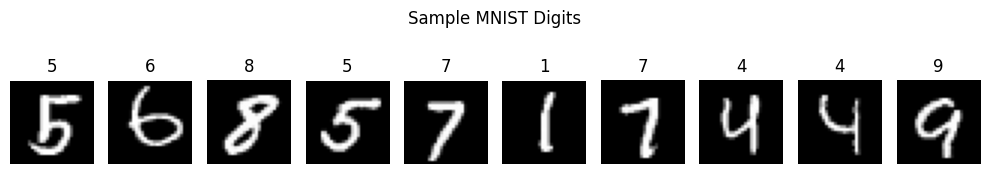

In [4]:
example_indices = np.random.choice(len(X), size=10)

plt.figure(figsize=(10, 2))
for i, idx in enumerate(example_indices):
    plt.subplot(1, len(example_indices), i + 1)
    plt.imshow(X[idx].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(str(Y[idx]))  # assuming labels are in Y

plt.suptitle("Sample MNIST Digits")
plt.tight_layout()
plt.show()

### Train-Test-Split

In [5]:
from courselib.utils.splits import train_test_split_np

training_data_fraction = .8

X_train, Y_train, X_test, Y_test = train_test_split_np(X,Y, training_data_fraction)

### Labels Encoding

In [6]:
from courselib.utils.preprocessing import labels_encoding

labels = sorted(np.unique(Y))
Y = labels_encoding(Y, labels=labels, pos_value=1, neg_value=0) 
Y_train = labels_encoding(Y_train, labels=labels, pos_value=1, neg_value=0) 
Y_test = labels_encoding(Y_test, labels=labels, pos_value=1, neg_value=0)

## 🏋️ MLP Training

We first demonstrate that a **ReLU MLP with two hidden layers** of **sufficient width** can already achieve good test accuracy on MNIST.

In this example, we use:
- Hidden layer sizes: **128** and **64** neurons
- Activation: **ReLU**
- Optimizer: **Mini-batch SGD**

> ⚠️ Training such a network with our custom backpropagation implementation is **computationally muuch more demanding** than all our previous models. As a result, training may take some time. We use SGD to speed up the process. 

In [ ]:
from courselib.models.nn import MLP
from courselib.optimizers import GDOptimizer
from courselib.utils.metrics import accuracy, mean_squared_error

metrics_dict = {
    "accuracy": accuracy,
    "MSE": mean_squared_error
}

optimizer = GDOptimizer(learning_rate=10.) # large LR to speed up training
model = MLP(widths=[28*28,128,64,10], optimizer=optimizer)

epoch_step = 5
max_epochs = 25

metrics_history = {}
for epoch in range(0,max_epochs,epoch_step):
    _metrics_history = model.fit(X_train, Y_train, num_epochs=epoch_step, batch_size=128, compute_metrics=True, metrics_dict=metrics_dict)
    for metric in _metrics_history:
        if metric in metrics_history:
            metrics_history[metric].extend(_metrics_history[metric])
        else:
            metrics_history[metric] = _metrics_history[metric]

    test_acc = accuracy(model.decision_function(X_test), Y_test)
    print(f'Epoch {epoch+epoch_step} | Train accuracy: {metrics_history['accuracy'][-1]:.2f}% | Test accuracy: {test_acc:.2f}')

Epoch 5 | Train accuracy: 94.78% | Test accuracy: 94.22
Epoch 10 | Train accuracy: 96.22% | Test accuracy: 95.59
Epoch 15 | Train accuracy: 97.01% | Test accuracy: 96.19
Epoch 20 | Train accuracy: 97.59% | Test accuracy: 96.66
Epoch 25 | Train accuracy: 97.92% | Test accuracy: 96.81


The final train accuracy: 97.9%
Test accuracy: 96.8%


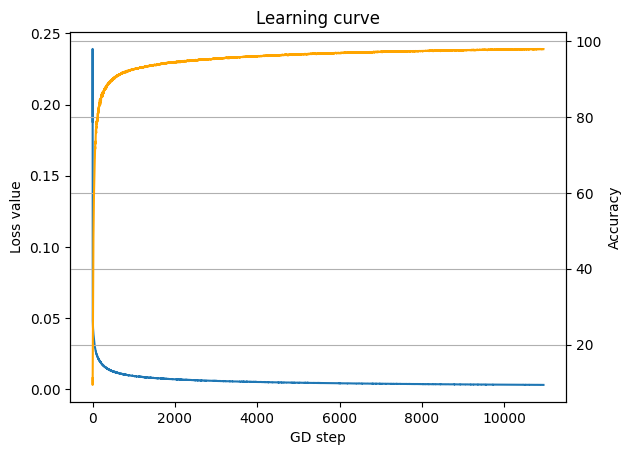

In [8]:
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history['MSE'])), metrics_history['MSE'])
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('GD step')

plt.title('Learning curve')
plt.grid()

print(f'The final train accuracy: {round(metrics_history['accuracy'][-1],1)}%')
print(f'Test accuracy: {round(accuracy(model.decision_function(X_test), Y_test),1)}%')

### ❌ Misclassified Examples

Below are several MNIST test images that the model classified incorrectly. Each image shows the true label and the model's predicted label.

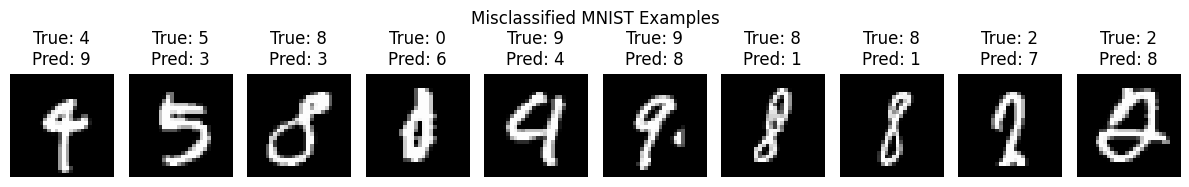

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get model predictions
Y_pred_labels = model(X_test)
Y_true_labels = np.argmax(Y_test, axis=1)  # assuming one-hot labels

# Find misclassified indices
misclassified = np.where(Y_true_labels != Y_pred_labels)[0]

# Select a few to display
n_show = 10
sample_indices = misclassified[:n_show]

plt.figure(figsize=(12, 2))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, n_show, i + 1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {Y_true_labels[idx]}\nPred: {Y_pred_labels[idx]}")
    plt.axis("off")

plt.suptitle("Misclassified MNIST Examples")
plt.tight_layout()
plt.show()


### Confusion Matrix

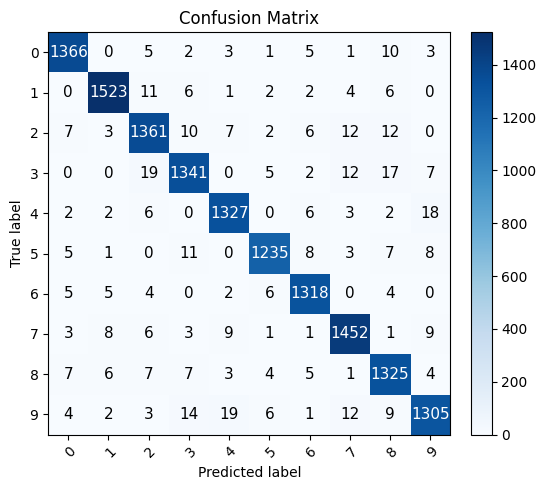

In [10]:
from courselib.utils.metrics import confusion_matrix

confusion_matrix(Y_test, model.decision_function(X_test), num_classes=None, plot=True, class_names=labels)

## 🏗️ Architectures Benchmark

We evaluate several MLP architectures with different layer widths and depths to observe their effects on **training time** and **accuracy**.

Each model is trained using the same optimizer and number of epochs for a fair comparison.

In [11]:
import time

# format: (hidden layers activation, output layer activation, loss)
activation_and_loss = [("ReLU", "Linear", "MSE"), 
                       ("Sigmoid", "Linear", "MSE"),
                       ("ReLU", "Softmax", "CE"),
                       ("Sigmoid", "Softmax", "CE")]

architectures = [
    [784, 32, 10],
    [784, 64, 10],
    [784, 128, 10],
    [784, 32, 16, 10],
    [784, 64, 32, 10]
]

max_epochs = 20

results = []

for arch in architectures:
    for hidden_act, output_act, loss in activation_and_loss:
        print(f"🔧 Architecture: {arch}, Activations and Loss: {hidden_act, output_act, loss}")

        optimizer = GDOptimizer(learning_rate=10.0)
        model = MLP(
            widths=arch,
            optimizer=optimizer,
            activation=hidden_act,
            output_activation=output_act, 
            loss=loss                   
        )

        start = time.time()

        metrics_history = model.fit(
                X_train, Y_train,
                num_epochs=max_epochs,
                batch_size=128,
                compute_metrics=True,
                metrics_dict=metrics_dict
            )
            
        end = time.time()

        final_acc = metrics_history['accuracy'][-1]
        final_mse = metrics_history['MSE'][-1]

        test_acc = accuracy(model.decision_function(X_test), Y_test)

        results.append({
            "architecture": arch,
            "activation": (hidden_act, output_act, loss),
            "train_accuracy": metrics_history["accuracy"][-1],
            "train_mse": metrics_history["MSE"][-1],
            "test_accuracy": test_acc,
            "train_time_sec": round(end - start, 2),
        })

        print(f"✅ Train accuracy: {final_acc:.2f} | Test accuracy: {test_acc:.2f} | ⏱️ Time: {end - start:.2f}s\n")


🔧 Architecture: [784, 32, 10], Activations and Loss: ('ReLU', 'Linear', 'MSE')
✅ Train accuracy: 93.36 | Test accuracy: 92.59 | ⏱️ Time: 563.13s

🔧 Architecture: [784, 32, 10], Activations and Loss: ('Sigmoid', 'Linear', 'MSE')
✅ Train accuracy: 92.16 | Test accuracy: 91.62 | ⏱️ Time: 710.50s

🔧 Architecture: [784, 32, 10], Activations and Loss: ('ReLU', 'Softmax', 'CE')
✅ Train accuracy: 97.17 | Test accuracy: 96.04 | ⏱️ Time: 619.99s

🔧 Architecture: [784, 32, 10], Activations and Loss: ('Sigmoid', 'Softmax', 'CE')
✅ Train accuracy: 93.91 | Test accuracy: 93.40 | ⏱️ Time: 811.64s

🔧 Architecture: [784, 64, 10], Activations and Loss: ('ReLU', 'Linear', 'MSE')
✅ Train accuracy: 95.34 | Test accuracy: 94.70 | ⏱️ Time: 795.52s

🔧 Architecture: [784, 64, 10], Activations and Loss: ('Sigmoid', 'Linear', 'MSE')
✅ Train accuracy: 92.43 | Test accuracy: 92.11 | ⏱️ Time: 1116.63s

🔧 Architecture: [784, 64, 10], Activations and Loss: ('ReLU', 'Softmax', 'CE')
✅ Train accuracy: 97.94 | Test accu

### 📊 Results

In our benchmark, ReLU networks trained with **softmax + cross-entropy** achieve the best performance overall. This setup is standard for classification tasks in deep learning, while **MSE** is more typical for regression.

We observe that increasing the **number of parameters** (e.g. wider hidden layers) generally improves accuracy. However, spreading parameters across **more layers** doesn’t clearly help for MNIST — a relatively simple task that doesn’t require deep hierarchical features.

> Even a single hidden layer with sufficient width can reach strong performance.

Due to computational limits of our custom implementation, we avoid larger networks here. But with adding more parameters to **1–2 hidden ReLU layers** and **softmax-cross-entropy**, test accuracy of around **99%** is achievable.


In [13]:
import pandas as pd

df = pd.DataFrame(results)
df


,architecture,activation,train_accuracy,train_mse,test_accuracy,train_time_sec
0,"[784, 32, 10]","(ReLU, Linear, MSE)",93.362619,0.007519,92.585185,563.13
1,"[784, 32, 10]","(Sigmoid, Linear, MSE)",92.162640,0.009152,91.620830,710.50
2,"[784, 32, 10]","(ReLU, Softmax, CE)",97.166122,0.002226,96.035431,619.99
3,"[784, 32, 10]","(Sigmoid, Softmax, CE)",93.914394,0.004653,93.399529,811.64
4,"[784, 64, 10]","(ReLU, Linear, MSE)",95.335798,0.006309,94.699621,795.52
5,"[784, 64, 10]","(Sigmoid, Linear, MSE)",92.434064,0.009217,92.106579,1116.63
6,"[784, 64, 10]","(ReLU, Softmax, CE)",97.944680,0.001661,96.656904,858.91
7,"[784, 64, 10]","(Sigmoid, Softmax, CE)",94.317959,0.004399,93.770984,1284.44
8,"[784, 128, 10]","(ReLU, Linear, MSE)",96.444706,0.005380,95.863990,1303.05
9,"[784, 128, 10]","(Sigmoid, Linear, MSE)",93.185836,0.008989,92.792342,2239.57
